In [1]:
import deconv as dv

import torch
import pandas as pd
import scanpy as sc

%load_ext autoreload
%autoreload 2

/home/lutrarutra/miniforge3/envs/dv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.__version__, dv.__version__, torch.__version__

('1.11.0', '0.9.3', '2.6.0+cu124')

In [3]:
# Download data from: https://xuranw.github.io/MuSiC/articles/pages/data.html
# ExpressionSet: 'XinT2Deset.rds' (Single cell RNA-seq data of pancreatic islet from healthy and diseased individuals(Xin et al.))
# ExpressionSet: 'EMTABesethealthy.rds' (Single cell RNA-seq data of pancreatic islets from healthy individuals (Segerstolpe et al.))
# Use the rds_to_csv.r script to convert to csv

reference_file = "../data/xin/sc.txt"
reference_mdata_file = "../data/xin/pdata.txt"
bulk_file = "../data/xin/bulk.txt"
cell_types = ["alpha", "delta", "gamma", "beta"]

### 1. Read data + basic QC

In [4]:
adata = sc.read_csv(reference_file, first_column_names=True, delimiter="\t")

pheno_df = pd.read_table(reference_mdata_file, index_col=0)
pheno_df.index.name = None
common_cells = list(set(pheno_df.index.tolist()) & set(adata.obs_names.tolist()))


adata = adata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
adata.obs["labels"] = pheno_df["cellType"].tolist()
adata.obs["labels"] = adata.obs["labels"].astype("category")

adata = adata[adata.obs["labels"].astype("str").isin(cell_types), :].copy()

# pd.DataFrame(data=adata.X, index=adata.obs["labels"], columns=adata.var_names).to_csv("../data/xin/sc.tsv", sep="\t")

print(adata.obs.groupby("labels").size())

bulk_df = pd.read_table(bulk_file, index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_counts=100)

/tmp/ipykernel_36910/3668109417.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby("labels").size())


labels
alpha    443
beta     171
delta     59
gamma     75
dtype: int64
bulk RNA-seq data - samples: 18, genes: 39849


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2. Initialize model

In [42]:
decon = dv.DeconV(
    adata,
    bulk=bulk_df,
    cell_type_key="labels",         # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="gamma",             # Gamma, Beta, nb, lognormal, or static    
    device=device,
    layer=None,
    top_n_variable_genes=15000,
    fp_hack=True,
    model_bulk_dropout=False
)

Using 15000 common genes between the reference and the bulk data.
Rounding counts to integers.


### 3. Train the reference model

In [43]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:30<00:00, 66.40it/s, loss=3.66e+05, lr=1.35e-02]


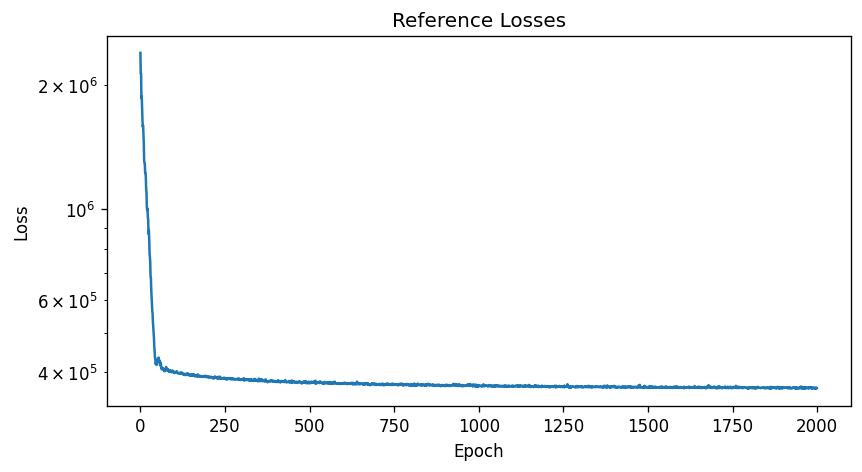

In [44]:
decon.plot_reference_losses()

### (Optional): Asses fit of the model

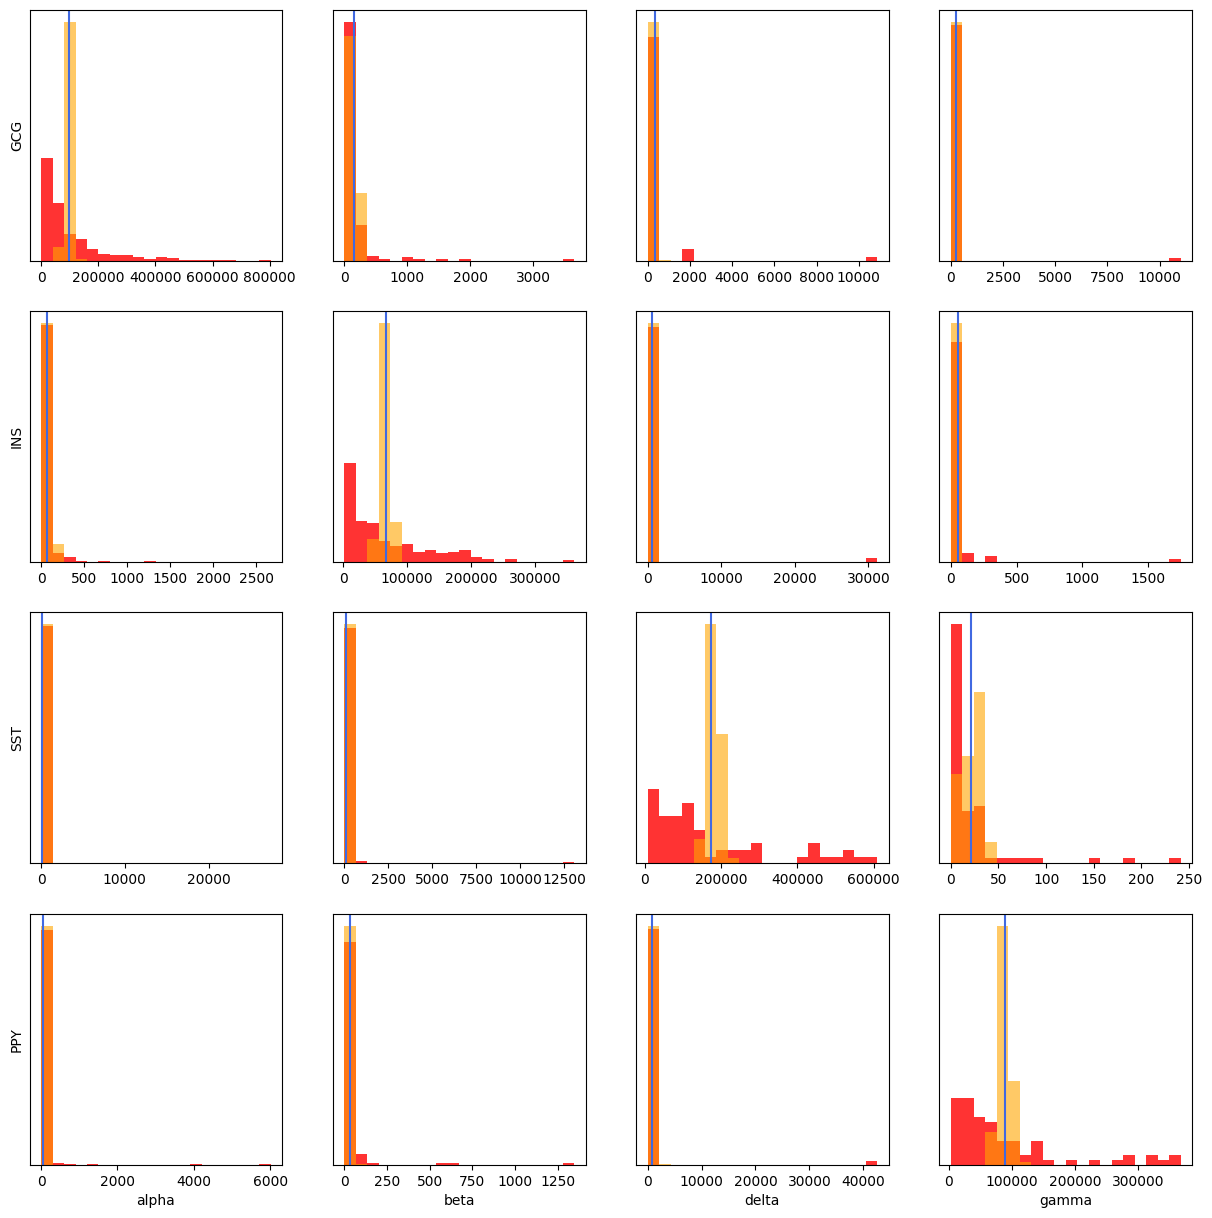

In [45]:
decon.check_fit()

### 4. Deconvolute

In [50]:
proportions = decon.deconvolute(lrd=0.999, lr=0.1, num_epochs=2000)
proportions

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:11<00:00, 174.05it/s, loss=6.86e+08, lr=1.35e-02]


,alpha,beta,delta,gamma
Non T2D 1,0.470870,0.397053,0.040950,0.091126
Non T2D 2,0.131727,0.641480,0.025353,0.201440
Non T2D 3,0.714982,0.171251,0.049948,0.063819
Non T2D 5,0.460064,0.399339,0.090788,0.049809
Non T2D 6,0.822888,0.115341,0.061764,0.000007
Non T2D 7,0.324969,0.489470,0.000002,0.185559
Non T2D 8,0.351970,0.345827,0.098394,0.203809
Non T2D 9,0.650582,0.159484,0.002895,0.187039
Non T2D 10,0.534680,0.416066,0.049251,0.000003
Non T2D 11,0.649290,0.253606,0.010686,0.086418


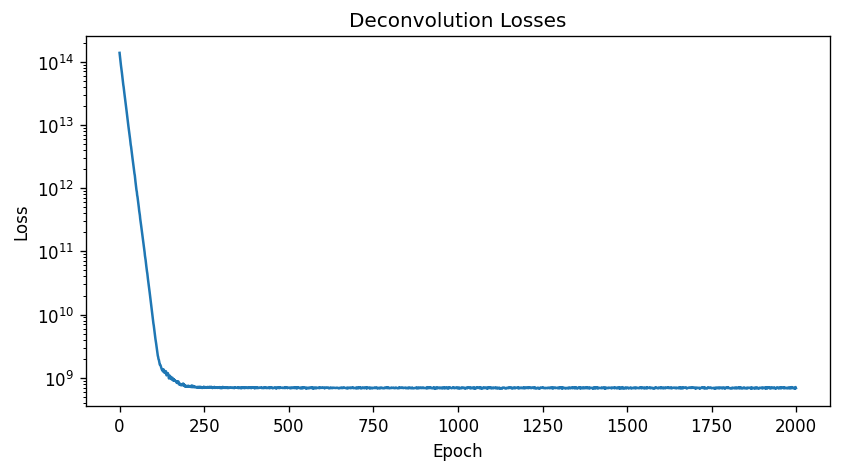

In [51]:
decon.plot_deconvolution_losses()

### Visualize results

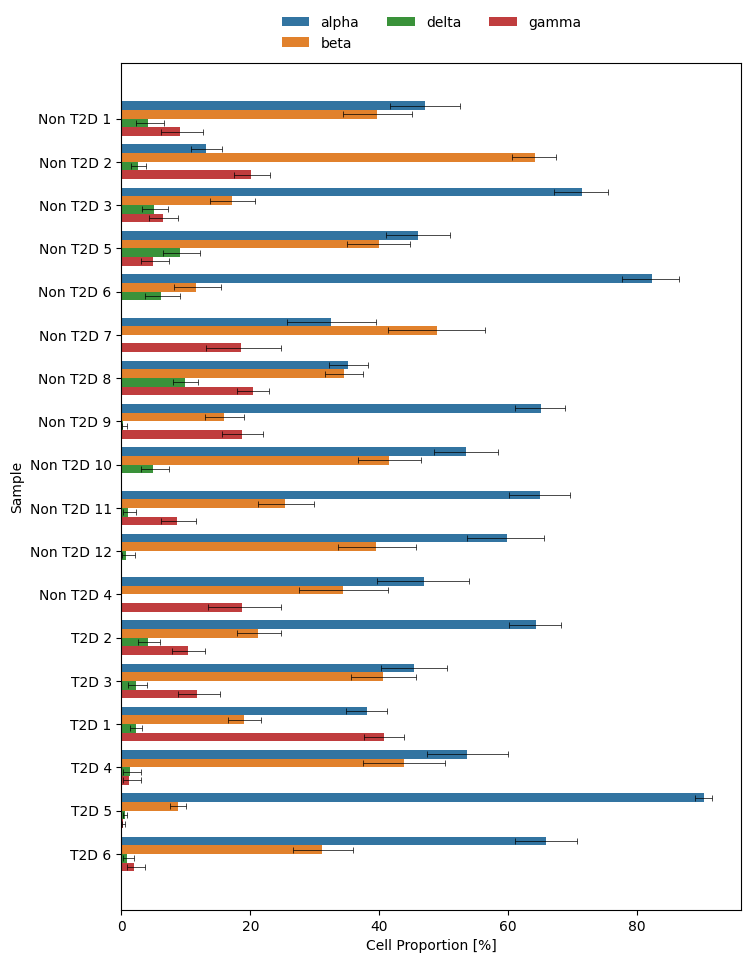

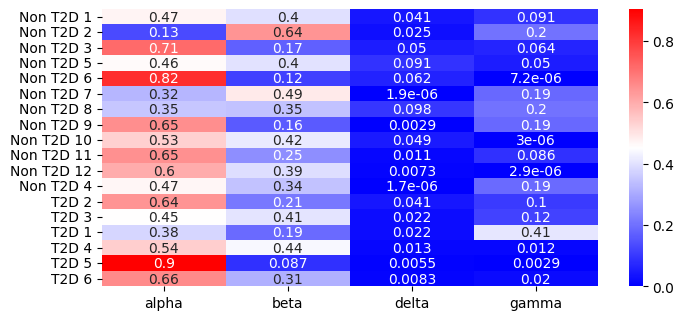

In [52]:
decon.plot_bar_proportions(path="figures/xin_bar_proportions.png")
decon.plot_heatmap_proportions(path="figures/xin_heatmap_proportions.png")

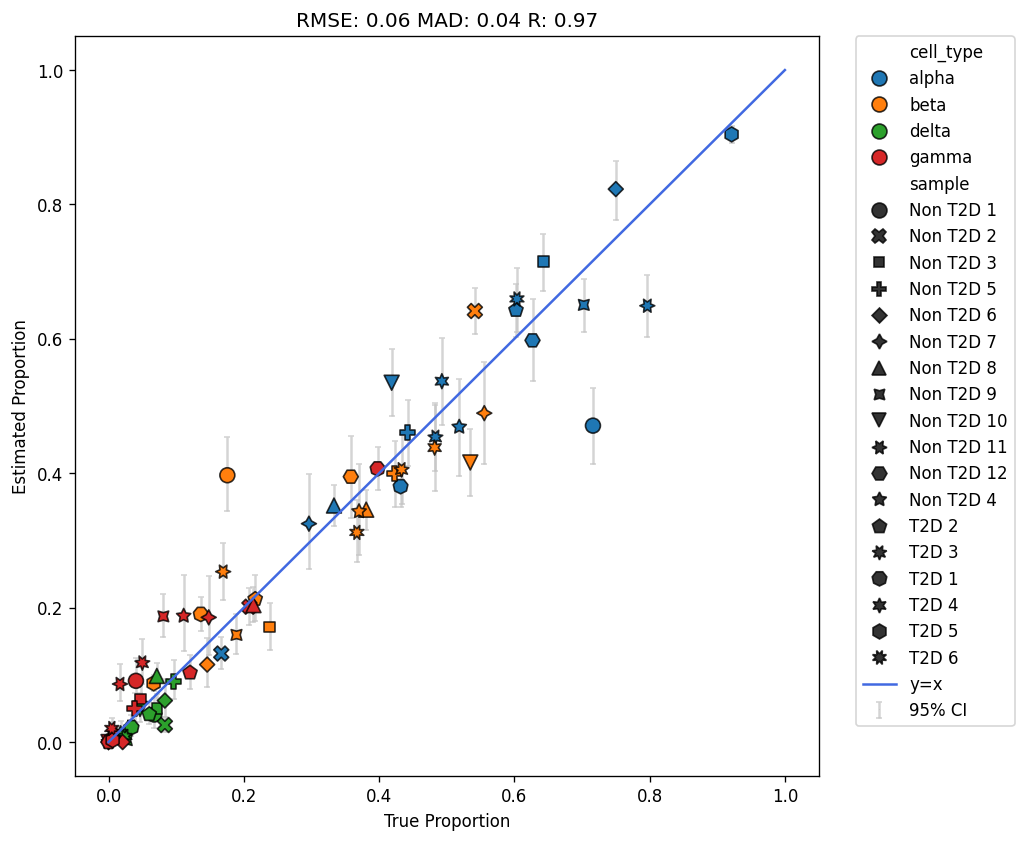

In [53]:
true_df = pd.read_table("../data/xin/proportions.txt", index_col=0)
decon.plot_benchmark_scatter(true_df=true_df, path="figures/xin_benchmark_scatter.png")